## Exploring the Impacts of the Thomas Fire on Air Quality and Land in CA

Author : Mariam Garcia

Github Link : https://github.com/mariamkg00/eds-220-hwk-4-task-3

### About

In this notebook, I aim to generate a false color image showing the fire scar left from the Thomas Fire, as well as visualizing its impact on Air Quality Index.

### Highlights

- using `rioxr` to open and visualize raster data
- geospatial data transformation with `geopandas`
- data visualization and filtering

### About the data

In this project, we will use three datasets.

**First Dataset**

The first dataset (accessed via URL) contains Daily Air Quality Index Data by County in 2017-2018.

**Second Dataset**

The second dataset is a simplified collection of bands from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.

**Third Dataset**

The third dataset contains the shapefile for which fire perimeters in California during 2017 took place. 

**Fourth Dataset**

The fourth and final dataset is a TIGER Shapefile from the US Census Bureau. This will provide the needed shapefile for the United States. 

### Final Output

The final visualizations for the fire perimeter of the Thomas Fire and its impact on AQI should result in this:

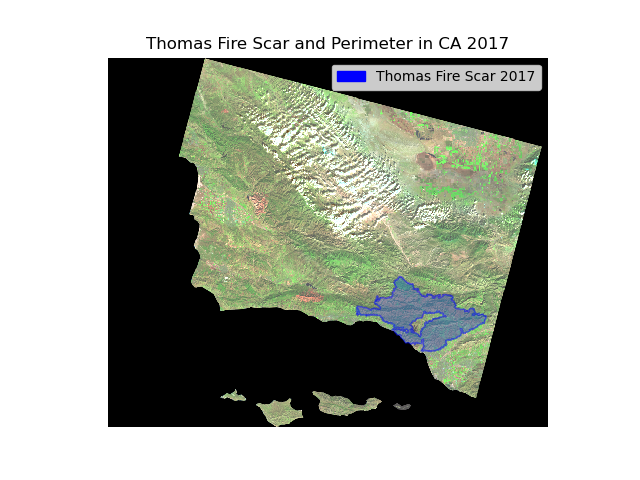

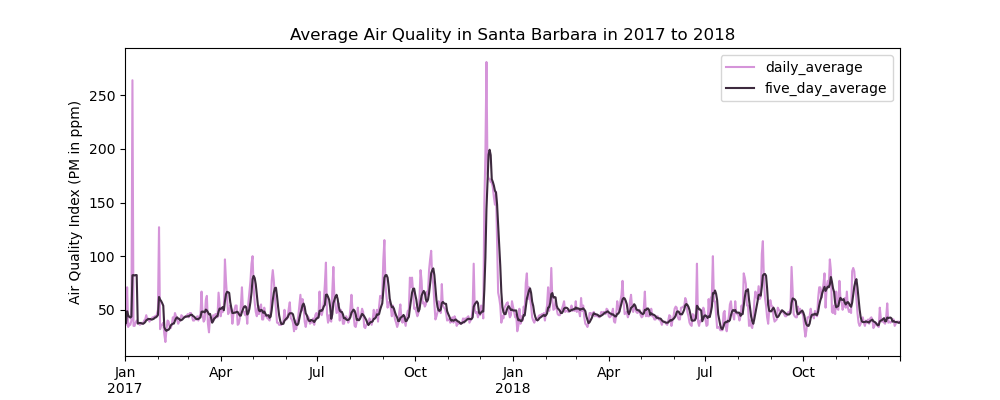


## Importing needed libraries and functions

In [1]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rioxr
import matplotlib.patches as mpatches

import geopandas as gpd
from shapely.geometry import Polygon

### AQI Data Access 

In order to access daily AQI data, please see this link :https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

When prompted, hover over `daily_aqi_by_county_2017.zip` and `daily_aqi_by_county_2018.zip` to copy the URLs for the zip files. 

We will use `pandas`'s `read_csv()` function to load in the data files. 

In [2]:
#reading in the 2017 data from the URL
url = 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip'
aqi_17 = pd.read_csv(url)

#reading in the 2018 data from the URL 
url2 = 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip'
aqi_18 = pd.read_csv(url2)

### Importing other datasets

We will use the `geopandas.read_file()` function to read in the TIGER shapefile data for US states.

In [3]:
# Importing US Shapefile
states = gpd.read_file('data/tl_us_2022_state/tl_2018_us_state.shp')
# update column names to small caps
states.columns = states.columns.str.lower()


We will use `os` in order to avoid hard coding, which can help make inputting file paths more reproducible. 

In order to make sure the landsat data for Santa Barbara is loaded in correctly, we will use `rioxr.open_rasterio()`
function as a way to open this .nc file.

In [4]:
# -- importing data
landsat_sb_fp = os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc')

landsat_sb = rioxr.open_rasterio(landsat_sb_fp)

# importing CA shapefile
ca = gpd.read_file(os.path.join('data','California_Fire_Perimeters_2017','California_Fire_Perimeters_2017.shp'))

### Preparing,Previewing, and Updating AQI Data

In order to access 2017 and 2018 AQI data for Santa Barbara, we will use the pandas `.concat()` function to join the two datasets together.

In order to only access Santa Barbara data, using the `.loc` function will help us filter. 



In [5]:
# using pd.concat() to merge the two dataframes together
aqi = pd.concat([aqi_17, aqi_18])

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')

# filtering for data only from santa barbara
aqi_sb = aqi.loc[aqi['county_name'] == 'Santa Barbara']


#removing state_name, county_name, state_code, and county_code columns from aqi_sb using drop
aqi_sb = aqi_sb.drop(columns = ['state_name','county_name','state_code','county_code'])



Notice that the `Date` column is stored as an `object`, instead of a `DateTime` object.

In [6]:
# updating date column using to_datetime() function
aqi_sb.date = pd.to_datetime(aqi_sb.date)

# updating the index of aqi_sb using set_index
aqi_sb = aqi_sb.set_index('date')

Calculating an average over a rolling window:

`rolling()` is a method for pandas.series that provides rolling window calculations.

A rolling average is critical to have as it continues to update the dataset's mean up until the nth term. This entails that each rolling average observation only includes values up until the nth term of a dataset. Rolling averages are important to use when analyzing data over time in order to visualize fluctuations that may occur within a dataset.


Without making any new variables, we will add the mean of the AQI over a 5-day rolling window as a new column named 'five_day_average' to the `aqi_sb` dataframe:

In [8]:
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

In [9]:
# adding daily averages to aqi_sb
# as of now we only have five day average, we need daily average.
aqi_sb['daily_average']= aqi_sb.aqi.resample('D').mean()

In [10]:
# tidying the ca dataset

ca.columns = ca.columns.str.lower()

### Preparing, Previewing, and Updating Landsat Data and CA Fire Data

In [11]:
# ------exploring landsat file-------

# exploring the netcdf file
type(landsat_sb) 

print(type(landsat_sb.values))
landsat_sb.values


# ------- exploring CA wildfire data ------

print('crs:' ,ca.crs)
print('shape of ca data:' ,ca.shape)


<class 'method'>
crs: epsg:3857
shape of ca data: (608, 23)


#### Updates

It is important to use the `squeeze()` and `drop()` functions in order to get rid of any unncessary and unneeded bands, because it makes the `landsat_sb` datset three-dimensional when it is not needed.

In [12]:
# dropping band and using squeeze
landsat_sb = landsat_sb.squeeze()

# dropping band dimension
landsat_sb = landsat_sb.drop('band')


##### Preliminary mapping

Selecting the red, green and blue variables of the `landsat_sb` xarray.Dataset, convert it to a numpy.array using the to_array() method, and then use .plot.imshow() to create an RGB image with the data.

Adjusting the scale for the bands in order to get a true color image. In order to do so, input `(robust= True)`

Making a false color image *without making any new variables* by plotting the swir-22, near-infrared, and red variables.

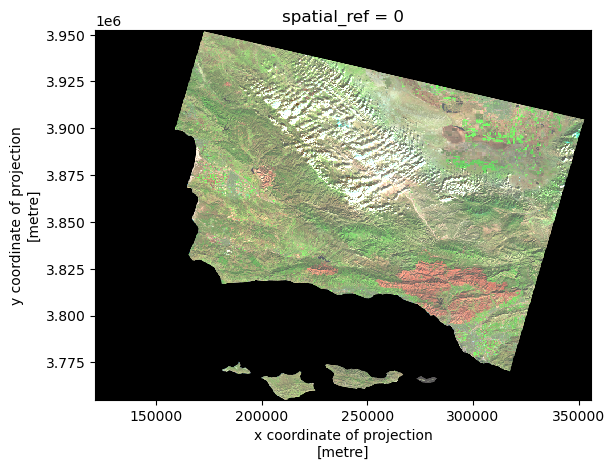

In [13]:
# making the false color image 
landsat_sb[['swir22','nir08','red']].to_array().plot.imshow(robust = True)

#### Making necessary updates

In order to have a functional plot, we must make sure that the crs's for both `ca` and `landsat_sb` match. 

In [14]:
# checking crs for fire data
ca.crs == landsat_sb.rio.crs


False

For legibility and clarity, it is optimal to have column names be lower cased, and this is done with the `.str.lower()` function.

In [15]:
# make column names small caps
ca.columns = ca.columns.str.lower()


We only want data pertaining to the *Thomas Fire*, so we will filter accordingly.

We will then use the `dissolve()` function in order to aggregate geometries based on the values in the `fire_name` column.

In [16]:
# selecting fire_name row for Thomas, subsetting CA wildfire data 
thomas_ca =ca[ca['fire_name'] == 'THOMAS'] 

# dissolving geometries 
thomas_ca = thomas_ca[['fire_name','geometry']].dissolve(by='fire_name', as_index=False)

It is imperative that the CRS's match for both `thomas_ca` and `ca` datasets. 
In order to transform the crs of `thomas_ca`, we will use the `to_crs()` 
function to change it to the `ca`'s CRS.

In [17]:
# the CRS's don't match, will change accordingly. 

thomas_ca = thomas_ca.to_crs('epsg:32611')

## Data Visualization

##### First, we will plot the AQI daily average and five day averages against each other.

**Objectives with plotting AQI:**

- constructing a line graph that contains both the 5-day averages and the daily average AQI in Santa Barbara *on top of each other*
- adding a legend indicating which line corresponds to which average
- using the date_time index column as the x-axis
- updating scale and axis labels
- incorporating a title 

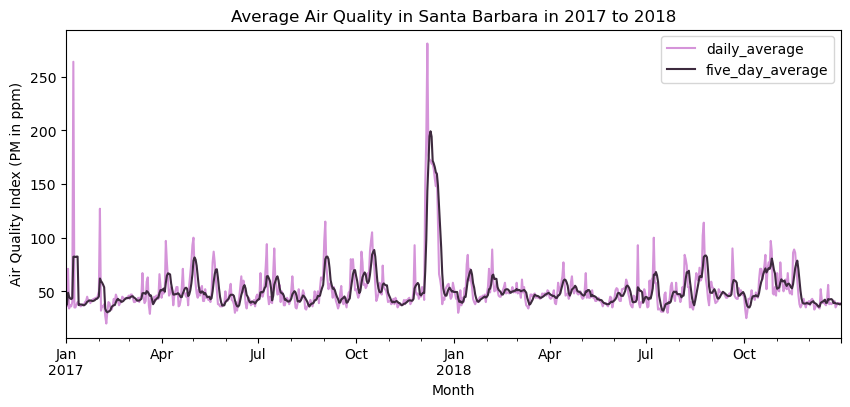

In [18]:
# plotting the daily and five day average Air Quality Index in Santa Barbara
fig, ax = plt.subplots(figsize=(10,4))

aqi_sb.daily_average.plot(ylabel = 'Air Quality Index (PM in ppm)',
                   xlabel = 'Date',
                   title = 'Daily Air Quality in Santa Barbara in 2017 to 2018',
                   legend = True,
                   color = '#D594D9')
aqi_sb.five_day_average.plot(ylabel = 'Air Quality Index (PM in ppm)',
                   xlabel = 'Month',
                   title = 'Average Air Quality in Santa Barbara in 2017 to 2018',
                   legend = True,
                   color = '#3D2A3E')

plt.savefig('images/aqi_sb_graph.png')

##### Now, we will make a map visualizing the Fire Perimeter of the Thomas Fire.

Objectives:

- ensuring that the false image coloring plot of the Thomas Fire is overlaying the landsat image 
- adding a legend indicating the perimeter to which the fire scar remains
- dissolving axis 
- adding a title

One way to add a customized legend to a plot is by using the `mpatches.Patch`. Using this, we are able to input any custom color and label. 

In this instance, I will input the `thomas_ca_patch` as blue.

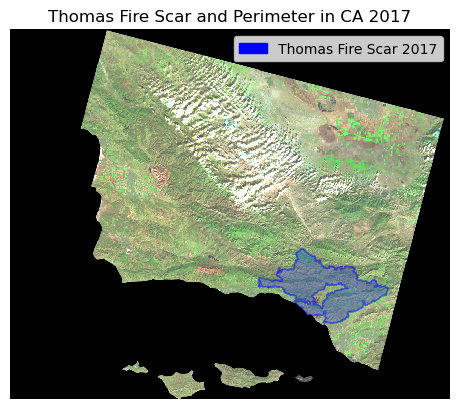

In [19]:
# making the map with both Thomas Fire perimeter and false color imagery
fig, ax = plt.subplots()
ax.axis('off')

#-----------landsat subplot customization--------------
landsat_sb[['swir22','nir08','red']].to_array().plot.imshow(ax=ax, robust = True)



#-----------Thomas Fire subplot customization---------------
thomas_ca.plot(ax=ax, edgecolor = 'blue', alpha = 0.5)
thomas_ca_patch = mpatches.Patch(color = 'blue',label = 'Thomas Fire Scar 2017')

#--------adding the needed customizations
ax.legend(handles = [thomas_ca_patch], frameon = True)
ax.set_title('Thomas Fire Scar and Perimeter in CA 2017')

#------ saving figure
# save figure

plt.savefig('images/thomas_fire_scar_2017.png')

#### Geographical Context

For geographical context, below is a plot generated to show the area impacted by the fire, followed by the entirety of the US.

For clarity and optimal visualization, only keep the state of California from the `states` dataset so that the Thomas Fire is visible.

In the following cells:

- subset the `states` dataset to only include California
- ensure the CRS's for both `states` and `thomas_ca` datasets match
- preliminary plot of California

In [20]:
# keeping only California
california = states[(states.name == 'California')]


# reprojecting crs of california subset to match thomas_ca crs

california = california.to_crs('epsg:32611')


Text(0.5, 1.0, 'Thomas Fire Scar Relative to the Entire State of California')

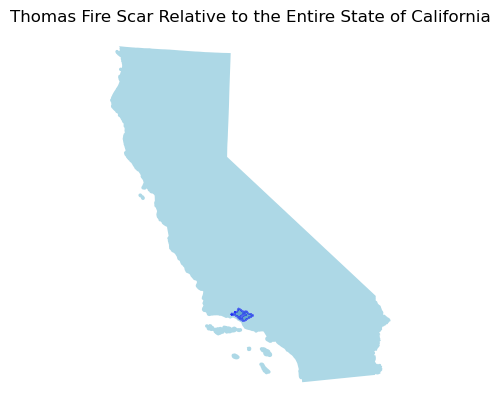

In [21]:
# plotting geographical context of the Thomas Fire relative to the size of the United States

fig, ax = plt.subplots()

ax.axis('off')

california.plot(ax = ax, color = 'lightblue')
thomas_ca.plot(ax=ax, edgecolor = 'blue', alpha = 0.5)
#thomas_ca_patch = mpatches.Patch(color = 'blue',label = 'Thomas Fire Scar 2017')

ax.set_title('Thomas Fire Scar Relative to the Entire State of California')
